In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
from pydub import AudioSegment
import glob
import librosa
import scipy.misc
import librosa.display
import numpy as np

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
# desired size of the output image
imsize = 512 if use_cuda else 128  # use small size if no gpu

imsize = (205, 110)
loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


style_img = image_loader("style_wave.jpg").type(dtype)
style_img = style_img.repeat(1,3,1,1)
style_img_orig = style_img
print('style_imge shape ', style_img.shape)
content_img = image_loader("content_wave.jpg").type(dtype)
content_img = content_img.repeat(1,3,1,1)
content_img_orig = content_img


print('content_imge shape ', content_img.shape)
print(content_img)
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


style_imge shape  torch.Size([1, 3, 205, 110])
content_imge shape  torch.Size([1, 3, 205, 110])
Variable containing:
( 0 , 0 ,.,.) = 
  0.9098  0.9137  0.9216  ...   0.8745  0.8588  0.8431
  0.9451  0.9098  0.8627  ...   0.7686  0.7569  0.7451
  1.0000  0.9843  0.9647  ...   0.7882  0.7765  0.7647
           ...             ⋱             ...          
  0.7647  0.7373  0.2941  ...   0.1569  0.2078  0.1608
  0.7647  0.7333  0.2902  ...   0.1412  0.1922  0.1451
  0.7686  0.7333  0.2902  ...   0.1059  0.1333  0.0667

( 0 , 1 ,.,.) = 
  0.9098  0.9137  0.9216  ...   0.8745  0.8588  0.8431
  0.9451  0.9098  0.8627  ...   0.7686  0.7569  0.7451
  1.0000  0.9843  0.9647  ...   0.7882  0.7765  0.7647
           ...             ⋱             ...          
  0.7647  0.7373  0.2941  ...   0.1569  0.2078  0.1608
  0.7647  0.7333  0.2902  ...   0.1412  0.1922  0.1451
  0.7686  0.7333  0.2902  ...   0.1059  0.1333  0.0667

( 0 , 2 ,.,.) = 
  0.9098  0.9137  0.9216  ...   0.8745  0.8588  0.8431
  0.9

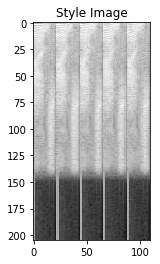

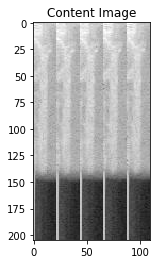

In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    #image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = image.view(3, 205, 110)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [6]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [8]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

In [9]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
#style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_layers_default = ['conv_3', 'conv_4', 'conv_5', 'conv_6']

def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

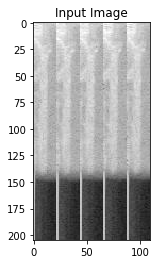

In [10]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

# add the original input image to the figure:
plt.figure()
imshow(input_img.data, title='Input Image')

In [11]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [12]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    
    style_loss = []
    content_loss = []
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            run[0] += 1
            if run[0] % 10 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                style_loss.append(style_score.data[0])
                content_loss.append(content_score.data[0])
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    #input_param.data.clamp_(0, 1)

    return input_param.data, style_loss, content_loss

In [13]:
"""
# Function that creates spectrogram of each WAV file
# Input: none
# Returns: nothing
"""
def convert_audio_to_spectrograms(accent_id, filename):
    reg_ex = accent_id + '_spectrograms\\' + filename +'*.wav'
    
    print('reg-ex is: ', reg_ex)
    wav_file_list = glob.glob(reg_ex)
    
    print('wave file list')
    print(wav_file_list)
    
    spectrogram_list = []
    
    for wav_file in wav_file_list:
        #print wav_file
        
        # Convert wav file to spectrogram (FFT)
        samples, sampling_rate = librosa.load(wav_file)
        
        # Comput STFT of the audio
        D = librosa.stft(samples)
            
        D_magnitude = np.abs(D)
        D_amp_to_db = librosa.amplitude_to_db(D_magnitude, ref=np.max)
        plt.pcolormesh(D_amp_to_db)
        librosa.display.specshow(D_amp_to_db, y_axis='log', x_axis='time')
        
        D_reshape = np.reshape(D_magnitude,(205,110,1))
        #print(D_reshape.shape)
        
        
        # Append to spectrogram list
        spectrogram_list.append(D_reshape)
        
    return spectrogram_list

In [14]:
def convert_to_spectrogram(input_wav_file):
    
    #--------------------------------------------------
    # SEGMENT WAV FILE
    #--------------------------------------------------
    split_wav_file = input_wav_file.split('.')
    wav_name = split_wav_file[0]
    audio_segments_dict = segment_audio_clip(input_wav_file, wav_name)
            
    #--------------------------------------------------
    # EXPORT AS WAV FILES
    #--------------------------------------------------
    split_wav_file = input_wav_file.split('_')
    accent_id = split_wav_file[0]
    export_audio_segments(audio_segments_dict, wav_name, accent_id)
    
    #--------------------------------------------------
    # CONVERT TO SPECTROGRAM
    #--------------------------------------------------
    new_input_wave_file = input_wav_file[:-4]
    spectrogram_list = convert_audio_to_spectrograms(accent_id, new_input_wave_file)
    #spectrogram_array = np.array(spectrogram_list)
        
    return spectrogram_list

In [15]:
"""
# Function that exports each audio segment to individual WAV files
# Input: dictionary of phoemes audio clips
# Returns: nothing
"""
def export_audio_segments(audio_segments_dict, wav_file_name, accent_id):
    
    for timestamp in audio_segments_dict:
        export_file_name = accent_id + '_spectrograms\\' + timestamp + '.wav'
        #export_file_name = timestamp + '.wav'
        
        #Exports to a wav file
        audio_segment = audio_segments_dict[timestamp]
        audio_segment.export(export_file_name, format="wav")

In [16]:
"""
# Function that parse audio from audio clip
# Input: wav file name, t1 (start of phoeme), t2 (end of phoeme)
# Returns: audio segments of individual phoeme between t1 and t2
"""
def parse_out_segment(audio_clip, t1, t2):
    
    # Grab audio segment between t1 and t2
    # First grab the first t2 milliseconds
    first_audio_segment = audio_clip[:t2]
    
    # Then grab the last t2-t1 milliseconds
    phoeme_length = t2 - t1
    audio_segment = first_audio_segment[-phoeme_length:]
    
    return audio_segment

In [17]:
"""
# Function that segments audio clip into smaller segments
# Input: wav file name, flag to shift by 250ms, flag to change volume
# Returns: dictionary of audio segments
"""
def segment_audio_clip(audio_file_name, wav_name):
    
    # Length is 1000ms = 1sec
    segment_length = 500
    
    # Read the audio file
    audio_clip = AudioSegment.from_wav(audio_file_name)
    #print audio_clip.duration_seconds
    
    # Calculate the number of segments based on audio clip duration and segment length
    audio_duration_ms = (audio_clip.duration_seconds)*1000    
    num_segments = int(audio_duration_ms / segment_length)
    #print num_segments
    
    # Segment the audio clip and save in dictionary
    segment_dict = {}
    
    for i in range(num_segments):
        key = wav_name + '_' + str(i)
        segment_audio = parse_out_segment(audio_clip, i*1000, i*1000+segment_length)
        segment_dict[key] = segment_audio
    
    return segment_dict

In [18]:
def improc(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    #image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = image.view(3, 205, 110)  # remove the fake batch dimension
    image = np.array(unloader(image))
    #print('image shape is ', image.shape)
    image= image[:,:,0]
    #print('image shape is: ', image.shape)
    #print('image shape after squeeze is ', image.shape)
    return image
    

In [ ]:
def transform_array_for_vgg_input(spec):
    
    print('spec input shape is: ', spec.shape)
    img = np.expand_dims(np.array(spec), axis = 0)
    img = img / 255
    img = np.expand_dims(img, axis = 0)
    img = torch.from_numpy(img).clone().float()
    img = img.repeat(1,3,1,1)
    img = img.cuda()
    img = Variable(img)
    return img
    

In [ ]:



if __name__ == "__main__":

   
    
    for k in range(1,16):
        content_name = 'ksp_arctic_a000' + str(k)+'.wav'
        style_name = 'bdl_arctic_a000'+ str(k)+'.wav'
        
        print(content_name)
        print(style_name)

        # Load the "content" spectrogram
        content_spectrogram_list = convert_to_spectrogram(content_name)    
        
        print('content spectrogram')
        print(content_spectrogram_list[0])
        content_spectrogram_list = [np.log10(x) for x in  content_spectrogram_list]
#         count = 1
#         for x in content_spectrogram_list:
#             print('current is image ', count)
#             print('max value is ', x.max())
#             print('min value is ', x.min())
#         image = content_spectrogram_list[0]



        # Load the "style" spectrogram
        style_spectrogram_list = convert_to_spectrogram(style_name)
        style_spectrogram_list = [np.log10(x) for x in  style_spectrogram_list]
#         count = 1
         
#         for x in content_spectrogram_list:
#             print('current is image ', count)
#             print('max value is ', x.max())
#             print('min value is ', x.min())
            
            
        
#         image = content_spectrogram_list[0]



#         style_spectrogram_list = [np.log10(x) for x in style_spectrogram_list]


#         image = np.reshape(image, [22,1025])
#     #     plt.imshow(image, cmap='magma',aspect = 'auto')

#     #     print ("STYLE shape = " + str(style_spectrogram_list[0].shape))
#     #     print ("CONTENT shape = " + str(content_spectrogram_list[0].shape))





        # Load the model

        # Initialize empty list to hold the generated spectograms
        generated_spectrogram_list = []

        # Run the model for each spectrogram segment
        num_segments_content = len(content_spectrogram_list)
        num_segments_style = len(style_spectrogram_list)
        num_segments = min(num_segments_content, num_segments_style)
        #num_segments = 1
        for i in range(num_segments):
            print('processing the ', i, 'th segments of total ', num_segments, ' segments')
            content_spec = content_spectrogram_list[i]
            style_spec = style_spectrogram_list[i]
#             content_img = transform_array_for_vgg_input(content_spec)
#             style_img = transform_array_for_vgg_input(style_spec)
            content_array = np.squeeze(content_spec, axis = -1)
            style_array = np.squeeze(style_spec, axis = -1)
            
            
            # get the max and min
            max_content = content_array.max()
            max_style = style_array.max()
            min_content = content_array.min()
            min_style = style_array.min()
            max_ = max(max_content, max_style)
            min_ = min(min_content, min_style)
            
            
            # do the transformation
            
            content_array = ((content_array - min_) * 255 / (max_ - min_))
            content_array = content_array.astype(int)
            style_array = ((style_array - min_) * 255 / (max_ - min_))
            style_array = style_array.astype(int)
            
            print('content_array', content_array)
            
            content_img = transform_array_for_vgg_input(content_array)
            style_img = transform_array_for_vgg_input(style_array)
            
            
            
            
            
#             print('content_array before saving image is: ')
#             print(content_array)
#             scipy.misc.imsave('content_wave.jpg', content_array)
#             print('content_array after saving image is: ')
#             content_img = scipy.ndimage.imread("content_wave.jpg")
#             print(content_img)
#             print('if we use image_loader')

#             content_img = image_loader("content_wave.jpg").type(dtype)
#             print(content_img)
            

#             scipy.misc.imsave('style_wave.jpg', style_array)





#             style_img = image_loader("style_wave.jpg").type(dtype)


#             style_img = style_img.repeat(1,3,1,1)
# #             print('style_imge shape ', style_img.shape)
# #             content_img = image_loader("content_wave.jpg").type(dtype)
#             content_img = content_img.repeat(1,3,1,1)

#             print('content_array after saving image is: ')
#             print(content_img)


    #         content_spec = np.reshape(content_spec, (1,1,content_spec.shape[0], content_spec.shape[1]))
    #         content_spec = torch.FloatTensor(content_spec)
    #         content_img = content_spec.clone()
    #         #content_img = Variable(content_img.repeat(1,3,1,1))

    #         style_spec = np.reshape(style_spec, (1,1,style_spec.shape[0], style_spec.shape[1]))
    #         style_spec = torch.FloatTensor(style_spec)
    #         style_img = style_spec.clone()
            #tyle_img = Variable(style_img.repeat(1,3,1,1))




            input_img = content_img.clone()

            output, style_loss, content_loss = run_style_transfer(cnn, content_img, style_img, input_img, num_steps=80,
                           style_weight=100, content_weight=1)
            print('generated output is: ', output)
            output = output.cpu().numpy()
            
            output = np.squeeze(output, axis = 0)
            output = np.mean(output, axis=0)
            print('output shape is: ', output.shape)
            print('before mapping output is:' )
            print(output)
            print('max_ - min_ is ', max_ - min_)
            print('min_ is ', min_)
            output = (output * (max_ - min_)  + min_)
            print('after mapping output is: ', output)
            output = np.power(10, output)
            generated_spectrogram_list.append(output)
            
            
            def print_loss_curve(style_loss, content_loss):
                itr = np.linspace(0, 80, 10)
                plt.figure(10)
                plt.plot(itr, style_loss)
                plt.plot(itr, content_loss)
                plt.plot(itr, [x+y for x, y in zip(style_loss, content_loss)])
                plt.legend(['style_loss', 'content_loss', 'total_loss'])
                plt.xlabel('iter')
                plt.ylabel('loss')
            
            print_loss_curve(style_loss, content_loss)
            
            
        print('double check before writing the numpy array')

        for x in generated_spectrogram_list:

            print('current x is: ')
            print(x)


        #generated_spectrogram_list = [np.exp(x) for x in generated_spectrogram_list]
        generated_spectrogram_list = [np.expand_dims(x, axis = 0) for x in generated_spectrogram_list]

        gen_spec_array = np.concatenate(generated_spectrogram_list, axis = 0)
        print('gen_spec_array shape is ', gen_spec_array.shape)
        spectrogram_file_name = 'gen_spec_array000' + str(k) + '.npy'
        np.save(spectrogram_file_name, gen_spec_array)



ksp_arctic_a0001.wav
bdl_arctic_a0001.wav
reg-ex is:  ksp_spectrograms\ksp_arctic_a0001*.wav
wave file list
['ksp_spectrograms\\ksp_arctic_a0001_0.wav', 'ksp_spectrograms\\ksp_arctic_a0001_2.wav', 'ksp_spectrograms\\ksp_arctic_a0001_5.wav', 'ksp_spectrograms\\ksp_arctic_a0001_3.wav', 'ksp_spectrograms\\ksp_arctic_a0001_4.wav', 'ksp_spectrograms\\ksp_arctic_a0001_1.wav']
content spectrogram
[[[7.12024514e-03]
  [5.56195080e-01]
  [1.06030262e+00]
  ...
  [1.48622656e+00]
  [9.82616782e-01]
  [3.56934011e-01]]

 [[8.71073604e-01]
  [8.38605881e-01]
  [6.82329595e-01]
  ...
  [1.69255698e+00]
  [4.32629776e+00]
  [8.72614574e+00]]

 [[3.64838809e-01]
  [6.99343562e-01]
  [4.93152678e-01]
  ...
  [1.63570206e+02]
  [1.00335831e+02]
  [7.02977448e+01]]

 ...

 [[3.94609116e-04]
  [1.97285946e-04]
  [3.12620259e-08]
  ...
  [2.32950015e-06]
  [2.68444661e-02]
  [1.15719914e-01]]

 [[3.94490547e-04]
  [1.97224232e-04]
  [4.12782803e-08]
  ...
  [8.78704725e-07]
  [3.82558405e-02]
  [1.8280576

run [10]:
Style Loss : 0.136646 Content Loss: 0.081618

run [20]:
Style Loss : 0.082178 Content Loss: 0.087641

run [30]:
Style Loss : 0.073593 Content Loss: 0.085139

run [40]:
Style Loss : 0.069871 Content Loss: 0.084748

run [50]:
Style Loss : 0.068852 Content Loss: 0.083919

run [60]:
Style Loss : 0.068239 Content Loss: 0.083668

run [70]:
Style Loss : 0.068082 Content Loss: 0.083293

run [80]:
Style Loss : 0.067802 Content Loss: 0.083196

run [90]:
Style Loss : 0.067609 Content Loss: 0.083091

run [100]:
Style Loss : 0.067489 Content Loss: 0.082966

generated output is:  
( 0 , 0 ,.,.) = 
  0.8824  0.8656  0.8827  ...   0.8257  0.8249  0.8333
  0.7652  0.8057  0.7655  ...   0.7638  0.7911  0.7775
  0.9146  0.9182  0.9103  ...   0.7378  0.7454  0.7349
           ...             ⋱             ...          
  0.7009  0.6871  0.2342  ...   0.1895  0.1508  0.1473
  0.6904  0.6551  0.2626  ...   0.1439  0.1587  0.1626
  0.7118  0.6716  0.2978  ...   0.1520  0.1301  0.1444

( 0 , 1 ,.,.)

run [10]:
Style Loss : 0.343388 Content Loss: 0.158541

run [20]:
Style Loss : 0.245244 Content Loss: 0.174070

run [30]:
Style Loss : 0.214593 Content Loss: 0.178492

run [40]:
Style Loss : 0.199980 Content Loss: 0.180488

run [50]:
Style Loss : 0.192366 Content Loss: 0.182090

run [60]:
Style Loss : 0.189592 Content Loss: 0.181732

run [70]:
Style Loss : 0.187391 Content Loss: 0.182059

run [80]:
Style Loss : 0.186521 Content Loss: 0.181641

run [90]:
Style Loss : 0.185155 Content Loss: 0.182005

run [100]:
Style Loss : 0.184768 Content Loss: 0.181629

generated output is:  
( 0 , 0 ,.,.) = 
  0.9223  0.8709  0.8254  ...   0.7964  0.8195  0.8065
  0.8628  0.8505  0.7770  ...   0.9103  0.8716  0.7982
  0.9080  0.8907  0.9238  ...   0.8978  0.8881  0.8291
           ...             ⋱             ...          
  0.7058  0.6767  0.3596  ...   0.2317  0.5654  0.6143
  0.7161  0.6770  0.3475  ...   0.2816  0.5648  0.6171
  0.6967  0.6749  0.3438  ...   0.3143  0.5212  0.5988

( 0 , 1 ,.,.)

run [10]:
Style Loss : 0.160438 Content Loss: 0.098205

run [20]:
Style Loss : 0.122920 Content Loss: 0.098049

run [30]:
Style Loss : 0.103152 Content Loss: 0.101234

run [40]:
Style Loss : 0.098771 Content Loss: 0.100660

run [50]:
Style Loss : 0.096844 Content Loss: 0.100339

run [60]:
Style Loss : 0.095648 Content Loss: 0.100238

run [70]:
Style Loss : 0.095040 Content Loss: 0.100020

run [80]:
Style Loss : 0.094354 Content Loss: 0.100145

run [90]:
Style Loss : 0.094233 Content Loss: 0.099828

run [100]:
Style Loss : 0.093982 Content Loss: 0.099728

generated output is:  
( 0 , 0 ,.,.) = 
  0.8851  0.8294  0.8559  ...   0.8405  0.8411  0.8188
  0.9042  0.8757  0.8217  ...   0.7696  0.7607  0.7018
  0.9036  0.9460  0.9274  ...   0.7457  0.7654  0.7501
           ...             ⋱             ...          
  0.7182  0.7129  0.2570  ...   0.1645  0.1745  0.1732
  0.7369  0.7191  0.2347  ...   0.1970  0.2046  0.1819
  0.7680  0.7128  0.2603  ...   0.0954  0.1302  0.0691

( 0 , 1 ,.,.)

run [10]:
Style Loss : 0.105924 Content Loss: 0.040369

run [20]:
Style Loss : 0.081940 Content Loss: 0.045445

run [30]:
Style Loss : 0.074625 Content Loss: 0.047706

run [40]:
Style Loss : 0.072733 Content Loss: 0.047855

run [50]:
Style Loss : 0.071597 Content Loss: 0.047990

run [60]:
Style Loss : 0.071001 Content Loss: 0.048021

run [70]:
Style Loss : 0.070563 Content Loss: 0.048106

run [80]:
Style Loss : 0.070263 Content Loss: 0.048150

run [90]:
Style Loss : 0.070123 Content Loss: 0.048092

run [100]:
Style Loss : 0.069875 Content Loss: 0.048166

generated output is:  
( 0 , 0 ,.,.) = 
  0.7882  0.7706  0.8196  ...   0.8262  0.8197  0.7947
  0.8408  0.8183  0.8105  ...   0.9211  0.8967  0.8072
  0.9025  0.9388  0.9543  ...   0.8013  0.8705  0.8780
           ...             ⋱             ...          
  0.5720  0.5639  0.2507  ...   0.2486  0.6489  0.7040
  0.5930  0.5658  0.2350  ...   0.2370  0.6206  0.6143
  0.5955  0.5636  0.2568  ...   0.2745  0.6277  0.6885

( 0 , 1 ,.,.)

content spectrogram
[[[1.27766550e-01]
  [6.22218382e-03]
  [6.07889712e-01]
  ...
  [4.32325214e-01]
  [2.28477627e-01]
  [4.95741814e-01]]

 [[6.99082389e-02]
  [2.93691009e-01]
  [3.36795688e-01]
  ...
  [7.92986917e+00]
  [5.72900343e+00]
  [1.28696842e+01]]

 [[1.67582912e+01]
  [1.17693710e+01]
  [3.58044648e+00]
  ...
  [2.46458793e+00]
  [1.96629453e+00]
  [5.46913147e+00]]

 ...

 [[7.73293246e-03]
  [3.86655540e-03]
  [9.54885380e-08]
  ...
  [3.38706826e-07]
  [1.77839946e-03]
  [1.32517675e-02]]

 [[7.72920297e-03]
  [3.86462244e-03]
  [3.03286960e-08]
  ...
  [4.42680715e-07]
  [4.81056748e-03]
  [2.89717875e-02]]

 [[7.72766257e-03]
  [3.86383035e-03]
  [2.46867220e-08]
  ...
  [4.88243529e-07]
  [6.64712768e-03]
  [4.10149321e-02]]]
reg-ex is:  bdl_spectrograms\bdl_arctic_a0003*.wav
wave file list
['bdl_spectrograms\\bdl_arctic_a0003_5.wav', 'bdl_spectrograms\\bdl_arctic_a0003_3.wav', 'bdl_spectrograms\\bdl_arctic_a0003_1.wav', 'bdl_spectrograms\\bdl_arctic_a0003_2.wav',

run [50]:
Style Loss : 0.152017 Content Loss: 0.133386

run [60]:
Style Loss : 0.150613 Content Loss: 0.132866

run [70]:
Style Loss : 0.149673 Content Loss: 0.132623

run [80]:
Style Loss : 0.149088 Content Loss: 0.132404

run [90]:
Style Loss : 0.148733 Content Loss: 0.132155

run [100]:
Style Loss : 0.148304 Content Loss: 0.132129

generated output is:  
( 0 , 0 ,.,.) = 
  0.7298  0.7609  0.8156  ...   0.8039  0.7649  0.8015
  0.8563  0.8238  0.7517  ...   0.7286  0.7277  0.7269
  0.9313  0.8853  0.9158  ...   0.7864  0.7723  0.7349
           ...             ⋱             ...          
  0.6972  0.6652  0.2782  ...   0.1826  0.1645  0.1348
  0.6799  0.6866  0.2442  ...   0.1598  0.1709  0.1710
  0.6991  0.6795  0.2093  ...   0.0859  0.1862  0.1980

( 0 , 1 ,.,.) = 
  0.7345  0.7819  0.8522  ...   0.8219  0.7838  0.8054
  0.8636  0.8316  0.7509  ...   0.7318  0.7175  0.7028
  0.9515  0.8994  0.9271  ...   0.7831  0.7685  0.7245
           ...             ⋱             ...          


run [10]:
Style Loss : 0.249859 Content Loss: 0.117830

run [20]:
Style Loss : 0.147380 Content Loss: 0.133048

run [30]:
Style Loss : 0.132590 Content Loss: 0.128581

run [40]:
Style Loss : 0.125295 Content Loss: 0.127604

run [50]:
Style Loss : 0.121474 Content Loss: 0.127136

run [60]:
Style Loss : 0.119742 Content Loss: 0.126616

run [70]:
Style Loss : 0.118578 Content Loss: 0.126439

run [80]:
Style Loss : 0.117979 Content Loss: 0.126078

run [90]:
Style Loss : 0.117282 Content Loss: 0.126052

run [100]:
Style Loss : 0.116804 Content Loss: 0.126000

generated output is:  
( 0 , 0 ,.,.) = 
  0.7512  0.8330  0.8640  ...   0.8076  0.7962  0.8218
  0.9034  0.8658  0.7651  ...   0.8025  0.7989  0.8035
  0.8729  0.9625  0.9683  ...   0.7739  0.7615  0.7804
           ...             ⋱             ...          
  0.7065  0.6686  0.2686  ...   0.1857  0.5173  0.6079
  0.7067  0.6703  0.2467  ...   0.1804  0.5166  0.5627
  0.7039  0.6787  0.2133  ...   0.1909  0.5340  0.6035

( 0 , 1 ,.,.)

run [10]:
Style Loss : 0.119424 Content Loss: 0.100178

run [20]:
Style Loss : 0.088501 Content Loss: 0.096682

run [30]:
Style Loss : 0.082156 Content Loss: 0.092476

run [40]:
Style Loss : 0.075195 Content Loss: 0.091797

run [50]:
Style Loss : 0.072007 Content Loss: 0.090354

run [60]:
Style Loss : 0.070313 Content Loss: 0.089930

run [70]:
Style Loss : 0.069420 Content Loss: 0.089533

run [80]:
Style Loss : 0.068912 Content Loss: 0.089218

run [90]:
Style Loss : 0.068632 Content Loss: 0.088890

run [100]:
Style Loss : 0.068384 Content Loss: 0.088682

generated output is:  
( 0 , 0 ,.,.) = 
  0.7951  0.7945  0.7713  ...   0.8133  0.8084  0.8040
  0.8003  0.7802  0.7500  ...   0.8228  0.7996  0.7736
  0.6530  0.7873  0.7932  ...   0.9200  0.8623  0.7511
           ...             ⋱             ...          
  0.5908  0.6098  0.2164  ...   0.2558  0.5942  0.6523
  0.5776  0.6047  0.2369  ...   0.2632  0.5603  0.6457
  0.5968  0.5709  0.1457  ...   0.2540  0.5389  0.6163

( 0 , 1 ,.,.)

run [10]:
Style Loss : 0.164337 Content Loss: 0.068009

run [20]:
Style Loss : 0.100555 Content Loss: 0.080469

run [30]:
Style Loss : 0.083945 Content Loss: 0.081700

run [40]:
Style Loss : 0.076885 Content Loss: 0.082616

run [50]:
Style Loss : 0.074713 Content Loss: 0.082141

run [60]:
Style Loss : 0.073537 Content Loss: 0.082213

run [70]:
Style Loss : 0.073089 Content Loss: 0.082115

run [80]:
Style Loss : 0.072614 Content Loss: 0.082235

run [90]:
Style Loss : 0.072464 Content Loss: 0.082109

run [100]:
Style Loss : 0.072260 Content Loss: 0.082110

generated output is:  
( 0 , 0 ,.,.) = 
  0.8010  0.7362  0.8077  ...   0.8277  0.8060  0.8103
  0.7541  0.7635  0.7558  ...   0.8508  0.8243  0.8399
  0.7666  0.7164  0.7212  ...   0.7842  0.7366  0.7573
           ...             ⋱             ...          
  0.5960  0.5685  0.1843  ...   0.1926  0.1797  0.1537
  0.5901  0.5755  0.2053  ...   0.1919  0.1871  0.2167
  0.6217  0.5740  0.2172  ...   0.1692  0.1779  0.2345

( 0 , 1 ,.,.)

Optimizing..
run [10]:
Style Loss : 0.339576 Content Loss: 0.176086

run [20]:
Style Loss : 0.191542 Content Loss: 0.207975

run [30]:
Style Loss : 0.162844 Content Loss: 0.208238

run [40]:
Style Loss : 0.157467 Content Loss: 0.205086

run [50]:
Style Loss : 0.153123 Content Loss: 0.204363

run [60]:
Style Loss : 0.150833 Content Loss: 0.203477

run [70]:
Style Loss : 0.149558 Content Loss: 0.202892

run [80]:
Style Loss : 0.148754 Content Loss: 0.202497

run [90]:
Style Loss : 0.147770 Content Loss: 0.202623

run [100]:
Style Loss : 0.147423 Content Loss: 0.202283

generated output is:  
( 0 , 0 ,.,.) = 
  0.8829  0.8257  0.8028  ...   0.8325  0.8167  0.7923
  0.8810  0.8260  0.7980  ...   0.7921  0.7540  0.7234
  0.8844  0.9321  0.9626  ...   0.7821  0.7792  0.7934
           ...             ⋱             ...          
  0.5817  0.5689  0.2878  ...   0.1920  0.1846  0.1410
  0.5645  0.5545  0.3001  ...   0.1746  0.2028  0.1834
  0.5989  0.5634  0.3314  ...   0.1347  0.1854  0.2041



Optimizing..
run [10]:
Style Loss : 0.046449 Content Loss: 0.033284

run [20]:
Style Loss : 0.033861 Content Loss: 0.032608

run [30]:
Style Loss : 0.030716 Content Loss: 0.032397

run [40]:
Style Loss : 0.029771 Content Loss: 0.031972

run [50]:
Style Loss : 0.029307 Content Loss: 0.031725

run [60]:
Style Loss : 0.029051 Content Loss: 0.031637

run [70]:
Style Loss : 0.028970 Content Loss: 0.031500

run [80]:
Style Loss : 0.028883 Content Loss: 0.031423

run [90]:
Style Loss : 0.028810 Content Loss: 0.031365

run [100]:
Style Loss : 0.028772 Content Loss: 0.031298

generated output is:  
( 0 , 0 ,.,.) = 
  0.8428  0.8039  0.8198  ...   0.8314  0.8229  0.7373
  0.8240  0.8008  0.7973  ...   0.7795  0.7768  0.7624
  0.9474  0.9440  0.9260  ...   0.7892  0.7907  0.7657
           ...             ⋱             ...          
  0.7104  0.6831  0.3572  ...   0.2301  0.2164  0.1996
  0.7110  0.6878  0.3360  ...   0.2132  0.1986  0.2220
  0.7233  0.6933  0.3189  ...   0.1090  0.2113  0.2114



run [10]:
Style Loss : 0.190700 Content Loss: 0.065175

run [20]:
Style Loss : 0.139356 Content Loss: 0.082191

run [30]:
Style Loss : 0.130942 Content Loss: 0.082750

run [40]:
Style Loss : 0.127076 Content Loss: 0.082971

run [50]:
Style Loss : 0.125521 Content Loss: 0.082761

run [60]:
Style Loss : 0.124792 Content Loss: 0.082516

run [70]:
Style Loss : 0.124068 Content Loss: 0.082586

run [80]:
Style Loss : 0.123564 Content Loss: 0.082578

run [90]:
Style Loss : 0.123381 Content Loss: 0.082361

run [100]:
Style Loss : 0.123028 Content Loss: 0.082377

generated output is:  
( 0 , 0 ,.,.) = 
  0.8324  0.7779  0.7947  ...   0.8197  0.7997  0.7056
  0.8076  0.7551  0.7726  ...   0.7485  0.7535  0.7265
  0.9520  0.9305  0.9029  ...   0.7686  0.7652  0.7435
           ...             ⋱             ...          
  0.6951  0.6637  0.3018  ...   0.1488  0.1384  0.1199
  0.6873  0.6736  0.2798  ...   0.1338  0.1160  0.1430
  0.7062  0.6845  0.2612  ...   0.0217  0.1228  0.1224

( 0 , 1 ,.,.)

processing the  0 th segments of total  6  segments
content_array [[234 232 230 ... 199 206 211]
 [213 217 221 ... 188 176 185]
 [247 246 249 ... 183 180 173]
 ...
 [178 172  83 ...  35  34  32]
 [178 172  79 ...  47  41  29]
 [178 172  80 ...  31  41  29]]
spec input shape is:  (205, 110)
spec input shape is:  (205, 110)
Building the style transfer model..
Optimizing..
run [10]:
Style Loss : 0.103094 Content Loss: 0.045905

run [20]:
Style Loss : 0.071461 Content Loss: 0.050913

run [30]:
Style Loss : 0.059546 Content Loss: 0.052188

run [40]:
Style Loss : 0.056297 Content Loss: 0.051418

run [50]:
Style Loss : 0.054898 Content Loss: 0.050942

run [60]:
Style Loss : 0.054438 Content Loss: 0.050619

run [70]:
Style Loss : 0.053947 Content Loss: 0.050662

run [80]:
Style Loss : 0.053798 Content Loss: 0.050519

run [90]:
Style Loss : 0.053667 Content Loss: 0.050452

run [100]:
Style Loss : 0.053574 Content Loss: 0.050383

generated output is:  
( 0 , 0 ,.,.) = 
  0.9123  0.8969  0.8958  

run [10]:
Style Loss : 0.103094 Content Loss: 0.045905

run [20]:
Style Loss : 0.071466 Content Loss: 0.050892

run [30]:
Style Loss : 0.059348 Content Loss: 0.052371

run [40]:
Style Loss : 0.056653 Content Loss: 0.051371

run [50]:
Style Loss : 0.055027 Content Loss: 0.051037

run [60]:
Style Loss : 0.054341 Content Loss: 0.050821

run [70]:
Style Loss : 0.054044 Content Loss: 0.050635

run [80]:
Style Loss : 0.053797 Content Loss: 0.050583

run [90]:
Style Loss : 0.053666 Content Loss: 0.050489

run [100]:
Style Loss : 0.053601 Content Loss: 0.050383

generated output is:  
( 0 , 0 ,.,.) = 
  0.9123  0.8969  0.8958  ...   0.7940  0.8160  0.8325
  0.8329  0.8402  0.8520  ...   0.7529  0.6955  0.7306
  0.9665  0.9486  0.9711  ...   0.7287  0.7173  0.6864
           ...             ⋱             ...          
  0.7018  0.6851  0.2954  ...   0.1585  0.1484  0.1433
  0.6803  0.6724  0.2871  ...   0.1998  0.1757  0.1275
  0.7064  0.6762  0.2858  ...   0.1392  0.1732  0.1234

( 0 , 1 ,.,.)

processing the  0 th segments of total  4  segments
content_array [[217 205 206 ... 200 201 204]
 [220 215 191 ... 211 215 218]
 [235 236 233 ... 225 241 239]
 ...
 [154 147  62 ...  60 181 197]
 [154 147  62 ...  64 177 189]
 [154 147  63 ...  62 181 198]]
spec input shape is:  (205, 110)
spec input shape is:  (205, 110)
Building the style transfer model..
Optimizing..
run [10]:
Style Loss : 0.381463 Content Loss: 0.161500

run [20]:
Style Loss : 0.226678 Content Loss: 0.198601

run [30]:
Style Loss : 0.194771 Content Loss: 0.205053

run [40]:
Style Loss : 0.183018 Content Loss: 0.204391

run [50]:
Style Loss : 0.174467 Content Loss: 0.205492

run [60]:
Style Loss : 0.169515 Content Loss: 0.206677

run [70]:
Style Loss : 0.166847 Content Loss: 0.207120

run [80]:
Style Loss : 0.165466 Content Loss: 0.207018

run [90]:
Style Loss : 0.164183 Content Loss: 0.207201

run [100]:
Style Loss : 0.163582 Content Loss: 0.206956

generated output is:  
( 0 , 0 ,.,.) = 
  0.8422  0.7819  0.8020  

run [10]:
Style Loss : 0.135346 Content Loss: 0.058746

run [20]:
Style Loss : 0.089257 Content Loss: 0.074567

run [30]:
Style Loss : 0.080231 Content Loss: 0.075257

run [40]:
Style Loss : 0.077943 Content Loss: 0.074230

run [50]:
Style Loss : 0.075829 Content Loss: 0.074465

run [60]:
Style Loss : 0.075075 Content Loss: 0.074174

run [70]:
Style Loss : 0.074262 Content Loss: 0.074283

run [80]:
Style Loss : 0.073830 Content Loss: 0.074164

run [90]:
Style Loss : 0.073469 Content Loss: 0.074096

run [100]:
Style Loss : 0.073200 Content Loss: 0.073980

generated output is:  
( 0 , 0 ,.,.) = 
  0.9239  0.8762  0.8544  ...   0.8271  0.8210  0.7845
  0.9286  0.8936  0.8199  ...   0.7645  0.7309  0.7185
  1.0002  0.9889  0.9681  ...   0.9150  0.8787  0.8058
           ...             ⋱             ...          
  0.6917  0.6698  0.2629  ...   0.2308  0.1823  0.1285
  0.6824  0.6513  0.2629  ...   0.2380  0.2103  0.1494
  0.7210  0.6705  0.2465  ...   0.2479  0.1833  0.1623

( 0 , 1 ,.,.)

run [10]:
Style Loss : 0.161041 Content Loss: 0.145681

run [20]:
Style Loss : 0.120130 Content Loss: 0.137683

run [30]:
Style Loss : 0.104289 Content Loss: 0.135277

run [40]:
Style Loss : 0.095489 Content Loss: 0.134350

run [50]:
Style Loss : 0.091291 Content Loss: 0.133846

run [60]:
Style Loss : 0.089776 Content Loss: 0.133388

run [70]:
Style Loss : 0.088993 Content Loss: 0.133180

run [80]:
Style Loss : 0.088616 Content Loss: 0.132941

run [90]:
Style Loss : 0.088298 Content Loss: 0.132829

run [100]:
Style Loss : 0.088084 Content Loss: 0.132709

generated output is:  
( 0 , 0 ,.,.) = 
  0.8364  0.8145  0.7925  ...   0.7835  0.7881  0.7830
  0.8315  0.8244  0.7669  ...   0.7914  0.7501  0.6454
  0.8660  0.9259  0.9561  ...   0.7826  0.7792  0.7230
           ...             ⋱             ...          
  0.5922  0.5665  0.2552  ...   0.1785  0.1494  0.1218
  0.6092  0.5660  0.2685  ...   0.1675  0.1344  0.0828
  0.6257  0.5955  0.2520  ...   0.1542  0.0878  0.1236

( 0 , 1 ,.,.)

run [10]:
Style Loss : 0.161068 Content Loss: 0.145689

run [20]:
Style Loss : 0.119248 Content Loss: 0.138357

run [30]:
Style Loss : 0.104918 Content Loss: 0.134674

run [40]:
Style Loss : 0.095818 Content Loss: 0.134265

run [50]:
Style Loss : 0.092052 Content Loss: 0.133650

run [60]:
Style Loss : 0.089905 Content Loss: 0.133480

run [70]:
Style Loss : 0.089031 Content Loss: 0.133261

run [80]:
Style Loss : 0.088670 Content Loss: 0.132939

run [90]:
Style Loss : 0.088307 Content Loss: 0.132825

run [100]:
Style Loss : 0.088102 Content Loss: 0.132679

generated output is:  
( 0 , 0 ,.,.) = 
  0.8368  0.8147  0.7926  ...   0.7836  0.7881  0.7833
  0.8314  0.8245  0.7670  ...   0.7915  0.7502  0.6456
  0.8663  0.9262  0.9565  ...   0.7826  0.7793  0.7231
           ...             ⋱             ...          
  0.5924  0.5662  0.2549  ...   0.1785  0.1491  0.1218
  0.6109  0.5680  0.2687  ...   0.1675  0.1344  0.0829
  0.6253  0.5951  0.2514  ...   0.1542  0.0879  0.1237

( 0 , 1 ,.,.)

FileNotFoundError: [Errno 2] No such file or directory: 'ksp_arctic_a00010.wav'

In [ ]:
output, _, _ = run_style_transfer(cnn, content_img, style_img, input_img)
# import numpy as np

# print('output shape', output.shape)
# plt.figure()
# imshow(output, title='Output Image')



def imshow1(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    #image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = image.view(3, 205, 110)  # remove the fake batch dimension
    image = np.array(unloader(image))
    print('image shape is ', image.shape)
    image= image[:,:,0]
    print('image shape is: ', image.shape)
    print('image shape after squeeze is ', image.shape)
    image = np.reshape(image, [1025,22])
    plt.imshow(image, cmap='magma',aspect = 'auto')
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# style_img = image_loader("style_wave.jpg").type(dtype)
# style_img = style_img.repeat(1,3,1,1)
# style_img_orig = style_img
# print('style_imge shape ', style_img.shape)
# content_img = image_loader("content_wave.jpg").type(dtype)
# content_img = content_img.repeat(1,3,1,1)
# content_img_orig = content_img


print('content image is: ')
imshow1(np.log(content_img_orig.data))
print('style image is: ')
imshow1(np.log(style_img_orig.data))
    
print('output image is: ')
imshow1(output)
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()